In [2]:
import pandas as pd
import json

In [12]:
df1=pd.read_csv("./ss/df_S_SI_effectveness.csv")
df1.head(2)

,embedding_model,classifier,seed,run,precision,recall,f1,nb_0,nb_1,elapsed_train,elapsed_test
0,bert-base-uncased,RandomForest,2573,1,1.000000,0.975022,0.987353,24641,1121,20.073,0.138
1,bert-base-uncased,CatBoost,2573,1,0.991119,0.995540,0.993324,24641,1121,9.499,0.019


In [14]:
df2=pd.read_csv("./si/df_I_SI_effectveness.csv")
df2.head(2)

,embedding_model,classifier,seed,run,precision,recall,f1,nb_0,nb_1,elapsed_train,elapsed_test
0,bert-base-uncased,RandomForest,9013,1,0.985075,0.808824,0.888291,24428.0,1224.0,23.986,0.130
1,bert-base-uncased,CatBoost,9013,1,0.880597,0.964052,0.920437,24428.0,1224.0,9.741,0.021


## 1. Effectiveness

In [ ]:
df1[["classifier","f1"]].groupby("classifier").agg(["mean","std"]).round(2) 

In [15]:
df2[["classifier","f1"]].groupby("classifier").agg(["mean","std"]).round(2) 

f1      
                    mean   std
classifier                    
CatBoost            0.92  0.00
DecisionTree        0.85  0.01
KNN                 0.87  0.01
LogisticRegression  0.39  0.01
MLP                 0.87  0.01
RandomForest        0.89  0.01
SVM                 0.71  0.01
XGBoost             0.93  0.01

In [17]:
classifiers_to_keep = [
    'XGBoost', 'CatBoost', 'RandomForest', 'MLP', 'DecisionTree',
    'KNN', 'SVM', 'LogisticRegression'
]

df_filtered = df2[df2['classifier'].isin(classifiers_to_keep)]

grouped = df_filtered.groupby(['classifier', 'embedding_model']).agg(
    mean_f1=('f1', 'mean'),
    std_f1=('f1', 'std'),
    mean_precision=('precision', 'mean'),
    std_precision=('precision', 'std'),
    mean_recall=('recall', 'mean'),
    std_recall=('recall', 'std')
).reset_index()

grouped['embedding_model'] = grouped['embedding_model'].replace({
    'bert-base-uncased': 'Scenario: Instance → schema with instance',
    'roberta-base': 'Scenario: Schema → schema with instance'  # optionnel selon ton cas
})

final_df = grouped[['classifier', 'embedding_model',
                    'mean_f1', 'std_f1',
                    'mean_precision', 'std_precision',
                    'mean_recall', 'std_recall']].round(2)

pivot = grouped.pivot(index='classifier', columns='embedding_model', values=[
    'mean_f1', 'std_f1',
    'mean_precision', 'std_precision',
    'mean_recall', 'std_recall'
]).round(2).reset_index()

pivot


,classifier,mean_f1,std_f1,mean_precision,std_precision,mean_recall,std_recall
embedding_model,,Scenario: Instance → schema with instance,Scenario: Instance → schema with instance,Scenario: Instance → schema with instance,Scenario: Instance → schema with instance,Scenario: Instance → schema with instance,Scenario: Instance → schema with instance
0,CatBoost,0.92,0.00,0.89,0.01,0.96,0.01
1,DecisionTree,0.85,0.01,0.87,0.01,0.84,0.01
2,KNN,0.87,0.01,0.93,0.01,0.81,0.02
3,LogisticRegression,0.39,0.01,0.25,0.00,0.89,0.01
4,MLP,0.87,0.01,0.87,0.02,0.87,0.02
5,RandomForest,0.89,0.01,0.99,0.00,0.81,0.01
6,SVM,0.71,0.01,0.56,0.01,0.98,0.01
7,XGBoost,0.93,0.01,0.92,0.01,0.93,0.01


## 2. Effeciency

In [19]:
import pandas as pd

classifiers_to_keep = [
    'XGBoost', 'CatBoost', 'RandomForest', 'MLP', 'DecisionTree',
    'KNN', 'SVM', 'LogisticRegression'
]

def aggregate_time_metrics(df, scenario_label):
    df_filtered = df[df['classifier'].isin(classifiers_to_keep)]

    grouped = df_filtered.groupby(['classifier', 'embedding_model']).agg(
        mean_train=('elapsed_train', 'mean'),
        std_train=('elapsed_train', 'std'),
        mean_test=('elapsed_test', 'mean'),
        std_test=('elapsed_test', 'std')
    ).reset_index()

    grouped['embedding_model'] = grouped['embedding_model'].replace({
        'bert-base-uncased': scenario_label
    })

    # Format en "mean ± std"
    def fmt(mean, std):
        return grouped[mean].round(2).astype(str) + " ± " + grouped[std].round(2).astype(str)

    grouped[f'{scenario_label}_train'] = fmt('mean_train', 'std_train')
    grouped[f'{scenario_label}_test'] = fmt('mean_test', 'std_test')

    return grouped[['classifier', f'{scenario_label}_train', f'{scenario_label}_test']]

train_test_df1 = aggregate_time_metrics(df1, "Scenario 1")
train_test_df2 = aggregate_time_metrics(df2, "Scenario 2")

merged_time = pd.merge(train_test_df1, train_test_df2, on='classifier')
merged_time

,classifier,Scenario 1_train,Scenario 1_test,Scenario 2_train,Scenario 2_test
0,CatBoost,9.19 ± 0.27,0.02 ± 0.0,9.92 ± 0.27,0.02 ± 0.0
1,DecisionTree,2.92 ± 0.12,0.0 ± 0.0,3.32 ± 0.3,0.0 ± 0.0
2,KNN,0.01 ± 0.0,1.33 ± 0.08,0.01 ± 0.0,1.37 ± 0.13
3,LogisticRegression,8.93 ± 0.43,0.0 ± 0.0,5.1 ± 0.26,0.0 ± 0.0
4,MLP,23.54 ± 3.75,0.01 ± 0.0,42.27 ± 4.81,0.02 ± 0.01
5,RandomForest,19.86 ± 0.43,0.13 ± 0.01,23.85 ± 0.28,0.13 ± 0.0
6,SVM,1059.46 ± 39.68,27.66 ± 1.27,561.87 ± 25.35,16.55 ± 0.41
7,XGBoost,0.55 ± 0.06,0.01 ± 0.0,0.62 ± 0.03,0.01 ± 0.0


## 3. Feature Importance

In [21]:
df1=pd.read_csv('./si/ablation_SI.csv')
df1.head()

,Features,F1,Recall,Precision,Seed,model,Execution
0,['Classiques'],0.815027,0.926770,0.727331,4571,bert,1.0
1,['Spectral'],0.802883,0.906428,0.720569,4571,bert,1.0
2,['Topology'],0.887050,0.872254,0.902357,4571,bert,1.0
3,"['Classiques', 'Spectral']",0.906396,0.945484,0.870412,4571,bert,1.0
4,"['Classiques', 'Topology']",0.926076,0.927583,0.924574,4571,bert,1.0


In [20]:
df2=pd.read_csv('./ss/ablation_SS.csv')
df2.head()

,Features,F1,Recall,Precision,Seed,model,Execution
0,['Classiques'],0.938552,0.977213,0.902834,3367,bert,1.0
1,['Spectral'],0.950806,0.982472,0.921118,3367,bert,1.0
2,['Topology'],0.991670,0.991236,0.992105,3367,bert,1.0
3,"['Classiques', 'Spectral']",0.993849,0.991236,0.996476,3367,bert,1.0
4,"['Classiques', 'Topology']",0.993424,0.992989,0.993860,3367,bert,1.0


## 4. Feature Selection

In [45]:

dict_distances={'Classiques': ['Euclidean',
  'Cosine',
  'Pearson',
  'Spearman',
  'Minkowski',
  'Canberra',
  'Chebyshev'],
 'Spectral': ['alpha_ReQ_a1',
  'alpha_ReQ_a2',
  'alpha_ReQ_A1',
  'alpha_ReQ_A2',
  'NESum_a1',
  'NESum_a2',
  'NESum_A1',
  'NESum_A2',
  'RankMe_a1',
  'RankMe_a2',
  'RankMe_A1',
  'RankMe_A2',
  'StableRank_a1',
  'StableRank_a2',
  'StableRank_A1',
  'StableRank_A2',
  'SelfCluster_a1',
  'SelfCluster_a2',
  'SelfCluster_A1',
  'SelfCluster_A2'],
 'Topology': ['h0_count_A1',
  'h1_count_A1',
  'h0_max_lifetime_A1',
  'h1_max_lifetime_A1',
  'euclidean_entropy_H0_A1',
  'euclidean_entropy_H1_A1',
  'h0_count_A2',
  'h1_count_A2',
  'h0_max_lifetime_A2',
  'h1_max_lifetime_A2',
  'euclidean_entropy_H0_A2',
  'euclidean_entropy_H1_A2',
  'h0_count_a1',
  'h1_count_a1',
  'h0_max_lifetime_a1',
  'h1_max_lifetime_a1',
  'euclidean_entropy_H0_a1',
  'euclidean_entropy_H1_a1',
  'h0_count_a2',
  'h1_count_a2',
  'h0_max_lifetime_a2',
  'h1_max_lifetime_a2',
  'euclidean_entropy_H0_a2',
  'euclidean_entropy_H1_a2',
  'h0_count_a1_a2',
  'h1_count_a1_a2',
  'h0_max_lifetime_a1_a2',
  'h1_max_lifetime_a1_a2',
  'euclidean_entropy_H0_a1_a2',
  'euclidean_entropy_H1_a1_a2',
  'euclidean_bottleneck_a1_a2',
  'euclidean_wasserstein_a1_a2',
  'euclidean_bottleneck_A1_A2',
  'euclidean_wasserstein_A1_A2',
  'cosine_entropy_H0_A1',
  'cosine_entropy_H1_A1',
  'cosine_entropy_H0_A2',
  'cosine_entropy_H1_A2',
  'cosine_entropy_H0_a1',
  'cosine_entropy_H1_a1',
  'cosine_entropy_H0_a2',
  'cosine_entropy_H1_a2',
  'cosine_entropy_H0_a1_a2',
  'cosine_entropy_H1_a1_a2',
  'cosine_bottleneck_a1_a2',
  'cosine_wasserstein_a1_a2',
  'cosine_bottleneck_A1_A2',
  'cosine_wasserstein_A1_A2',
  'manhattan_entropy_H0_A1',
  'manhattan_entropy_H1_A1',
  'manhattan_entropy_H0_A2',
  'manhattan_entropy_H1_A2',
  'manhattan_entropy_H0_a1',
  'manhattan_entropy_H1_a1',
  'manhattan_entropy_H0_a2',
  'manhattan_entropy_H1_a2',
  'manhattan_entropy_H0_a1_a2',
  'manhattan_entropy_H1_a1_a2',
  'manhattan_bottleneck_a1_a2',
  'manhattan_wasserstein_a1_a2',
  'manhattan_bottleneck_A1_A2',
  'manhattan_wasserstein_A1_A2']}

abbreviations={'Canberra': 'Canb',
 'Chebyshev': 'Cheb',
 'Euclidean': 'Eucl',
 'NESum_A1': 'NES_A1',
 'NESum_a1': 'NES_a1',
 'NESum_a2': 'NES_a2',
 'RankMe_A1': 'RM_A1',
 'RankMe_A2': 'RM_A2',
 'RankMe_a1': 'RM_a1',
 'RankMe_a2': 'RM_a2',
 'SelfCluster_A2': 'SC_A2',
 'SelfCluster_a1': 'SC_a1',
 'SelfCluster_a2': 'SC_a2',
 'alpha_ReQ_A2': 'aRQ_A2',
 'cosine_bottleneck_a1_a2': 'cosB_a1a2',
 'cosine_entropy_H0_A1': 'cosE0_A1',
 'cosine_entropy_H0_a1': 'cosE0_a1',
 'cosine_entropy_H0_a1_a2': 'cosE0_a1a2',
 'cosine_entropy_H0_a2': 'cosE0_a2',
 'cosine_entropy_H1_A1': 'cosE1_A1',
 'cosine_entropy_H1_a1': 'cosE1_a1',
 'cosine_entropy_H1_a1_a2': 'cosE1_a1a2',
 'cosine_entropy_H1_a2': 'cosE1_a2',
 'cosine_wasserstein_A1_A2': 'cosW_A1A2',
 'cosine_wasserstein_a1_a2': 'cosW_a1a2',
 'euclidean_bottleneck_a1_a2': 'eucB_a1a2',
 'euclidean_entropy_H0_A1': 'eucE0_A1',
 'euclidean_entropy_H0_a1': 'eucE0_a1',
 'euclidean_entropy_H0_a1_a2': 'eucE0_a1a2',
 'euclidean_entropy_H0_a2': 'eucE0_a2',
 'euclidean_entropy_H1_A1': 'eucE1_A1',
 'euclidean_entropy_H1_a1': 'eucE1_a1',
 'euclidean_entropy_H1_a1_a2': 'eucE1_a1a2',
 'euclidean_entropy_H1_a2': 'eucE1_a2',
 'euclidean_wasserstein_a1_a2': 'eucW_a1a2',
 'h0_max_lifetime_A1': 'h0ml_A1',
 'h0_max_lifetime_A2': 'h0ml_A2',
 'h0_max_lifetime_a1_a2': 'h0ml_a1a2',
 'h0_max_lifetime_a2': 'h0ml_a2',
 'h1_count_a1': 'h1c_a1',
 'h1_count_a1_a2': 'h1c_a1a2',
 'h1_max_lifetime_a1': 'h1ml_a1',
 'h1_max_lifetime_a1_a2': 'h1ml_a1a2',
 'h1_max_lifetime_a2': 'h1ml_a2',
 'manhattan_bottleneck_A1_A2': 'manB_A1A2'}

In [68]:

selected_features_ss=[]
for i in range(1,10,1):
    file_path = f"./ss/metriques_sorties_exec{i}.txt"


    with open(file_path, "r", encoding="utf-8") as f:
        selected_features = [line.strip() for line in f if line.strip()]
        
    selected_features_ss+=selected_features

    print("Selected Variables  ({}):".format(len(set(selected_features_ss))))
    print(selected_features_ss)

Selected Variables  (33):
['Canberra', 'Chebyshev', 'Euclidean', 'ExecutionTime', 'NESum_A1', 'NESum_a1', 'RankMe_A2', 'RankMe_a2', 'SelfCluster_a1', 'SelfCluster_a2', 'alpha_ReQ_A2', 'cosine_bottleneck_a1_a2', 'cosine_entropy_H0_A1', 'cosine_entropy_H0_a1', 'cosine_entropy_H0_a1_a2', 'cosine_entropy_H0_a2', 'cosine_entropy_H1_a1', 'cosine_entropy_H1_a1_a2', 'cosine_entropy_H1_a2', 'cosine_wasserstein_A1_A2', 'cosine_wasserstein_a1_a2', 'euclidean_entropy_H0_a1', 'euclidean_entropy_H0_a2', 'euclidean_entropy_H1_a1', 'euclidean_entropy_H1_a1_a2', 'euclidean_entropy_H1_a2', 'h0_max_lifetime_a1_a2', 'h0_max_lifetime_a2', 'h1_count_a1', 'h1_count_a1_a2', 'h1_max_lifetime_a1', 'h1_max_lifetime_a1_a2', 'manhattan_bottleneck_A1_A2']
Selected Variables  (33):
['Canberra', 'Chebyshev', 'Euclidean', 'ExecutionTime', 'NESum_A1', 'NESum_a1', 'RankMe_A2', 'RankMe_a2', 'SelfCluster_a1', 'SelfCluster_a2', 'alpha_ReQ_A2', 'cosine_bottleneck_a1_a2', 'cosine_entropy_H0_A1', 'cosine_entropy_H0_a1', 'cosi

In [69]:
selected_features_si=[]
for i in range(1,10,1):
    file_path = f"./si/metriques_sorties_exec{i}.txt"


    with open(file_path, "r", encoding="utf-8") as f:
        selected_features = [line.strip() for line in f if line.strip()]
        
    selected_features_si+=selected_features

    print("Selected Variables({}):".format(len(set(selected_features_si))))
    print(selected_features_si)

Selected Variables(36):
['Canberra', 'Chebyshev', 'Euclidean', 'NESum_A1', 'NESum_a1', 'NESum_a2', 'RankMe_A1', 'RankMe_a1', 'RankMe_a2', 'SelfCluster_A2', 'SelfCluster_a1', 'SelfCluster_a2', 'alpha_ReQ_A2', 'cosine_bottleneck_a1_a2', 'cosine_entropy_H0_a1', 'cosine_entropy_H0_a1_a2', 'cosine_entropy_H0_a2', 'cosine_entropy_H1_A1', 'cosine_entropy_H1_a1_a2', 'euclidean_bottleneck_a1_a2', 'euclidean_entropy_H0_A1', 'euclidean_entropy_H0_a1', 'euclidean_entropy_H0_a1_a2', 'euclidean_entropy_H1_A1', 'euclidean_entropy_H1_a1_a2', 'euclidean_entropy_H1_a2', 'euclidean_wasserstein_a1_a2', 'h0_max_lifetime_A1', 'h0_max_lifetime_A2', 'h0_max_lifetime_a1_a2', 'h0_max_lifetime_a2', 'h1_count_a1', 'h1_max_lifetime_a1', 'h1_max_lifetime_a1_a2', 'h1_max_lifetime_a2', 'manhattan_bottleneck_A1_A2']
Selected Variables(36):
['Canberra', 'Chebyshev', 'Euclidean', 'NESum_A1', 'NESum_a1', 'NESum_a2', 'RankMe_A1', 'RankMe_a1', 'RankMe_a2', 'SelfCluster_A2', 'SelfCluster_a1', 'SelfCluster_a2', 'alpha_ReQ_A2

In [48]:
selected_features_ss=set(selected_features_ss)
selected_features_si=set(selected_features_si)

In [49]:
all_features = sorted(selected_features_ss.union(selected_features_si))

def get_category(feature):
    for cat, feats in dict_distances.items():
        if feature in feats:
            return cat
    return "Other"

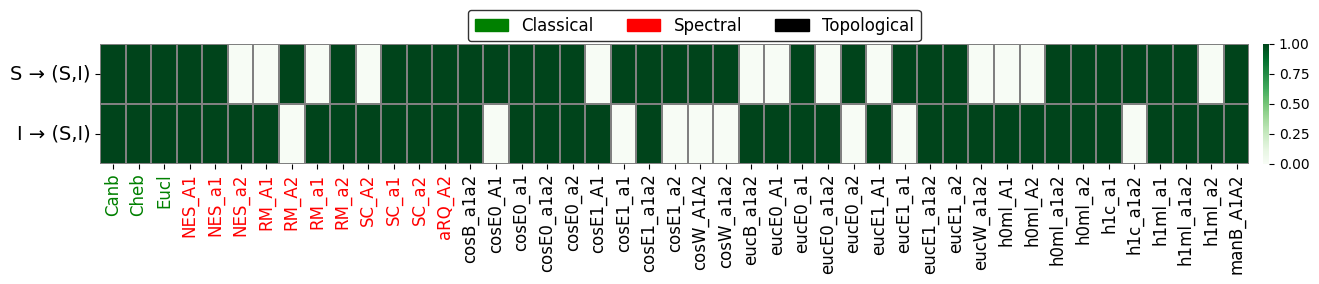

In [63]:
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.patches as mpatches
import pandas as pd

all_features = sorted(selected_features_ss.union(selected_features_si))
all_features = [f for f in all_features if f!='ExecutionTime' ]
all_abbr=[abbreviations[f] for f in all_features if f!='ExecutionTime' ]

df = pd.DataFrame({
    "Scenario 1: Schema → (S,I)": [1 if f in selected_features_ss else 0 for f in all_features],
    "Scenario 2: Instance → (S,I)": [1 if f in selected_features_si else 0 for f in all_features],
    "Category": [get_category(f) for f in all_features]
})

df.rename(columns={
    "Scenario 1: Schema → (S,I)": "S → (S,I)",
    "Scenario 2: Instance → (S,I)": "I → (S,I)"
}, inplace=True)

# Construction de la matrice pour la heatmap
heatmap_data = df[["S → (S,I)", "I → (S,I)"]].T
heatmap_data.columns = all_abbr
heatmap_data = heatmap_data.astype(float)

# === PARTIE 2 : Catégories ===
# On part de la colonne "Category" de df pour chaque feature
feature_list    = list(heatmap_data.columns)
feature_to_cat  = dict(zip(all_abbr, df["Category"]))
cat_map         = {"Classiques":"Classical", "Spectral":"Spectral", "Topology":"Topological"}
cat_colors      = {"Classical":"green", "Spectral":"red", "Topological":"black"}
feature_cats    = [feature_to_cat.get(f, 'Autre') for f in feature_list]
feature_cats_long = [cat_map.get(c, 'Other') for c in feature_cats]

# === PARTIE 3 : DataFrame seaborn ===
df_plot       = heatmap_data.copy()
df_plot.index = ["S → (S,I)", "I → (S,I)"]
# colonnes : feature_list, en ordre

# === PARTIE 4 : Tracé ===
fig, ax = plt.subplots(figsize=(max(12, len(df_plot.columns)*0.4), 6))

sns.heatmap(
    df_plot,
    cmap="Greens",
    cbar=True,
    cbar_kws={
        'orientation':'vertical',
        'shrink': 1,
        'pad': 0.01,
    },
    linewidths=0.3,
    linecolor='gray',
    ax=ax
)

# Coloration ticks X (features)
ax.set_xticklabels(df_plot.columns, rotation=90, ha='center')
for lbl, cat in zip(ax.get_xticklabels(), feature_cats_long):
    lbl.set_color(cat_colors[cat])
    lbl.set_fontsize(12)

# Coloration ticks Y (scénarios)
ax.set_yticklabels(df_plot.index, rotation=0, fontsize=14)

# === PARTIE 5 : LES LÉGENDES AU‐DESSUS ===

# 5A) Légende des couleurs de features
meta_patches = [
    mpatches.Patch(color=col, label=cat)
    for cat, col in cat_colors.items()
]
fig.legend(
    handles=meta_patches,
    fontsize=12,
    loc='upper center',
    bbox_to_anchor=(0.45, 0.57),
    ncol=len(meta_patches),
    frameon=True
).get_frame().set_edgecolor('black')

# 5B) Légende des scenarios (si vous voulez indiquer le mapping)
scenario_full = {
    "S → (S,I)": "Schema → (S,I)",
    "I → (S,I)": "Instance → (S,I)"
}
meth_patches = [
    mpatches.Patch(facecolor='white', edgecolor='black', label=f"{abbr} = {name}")
    for abbr, name in scenario_full.items()
]

# === PARTIE 6 : Ajustements finaux ===
fig.subplots_adjust(top=0.5, bottom=0.3, left=0.12, right=0.88)
plt.savefig('feature_selection_two.png', dpi=450, bbox_inches='tight')

plt.show()